# Competição Playground Series Season 3, Episode 5 (Parte 5.2 - Final)

Este notebook possui reune todas as decissões que foram tomadas ao longo das 5 partes para alcançar a **posição 67** no ranking da competição. 
![](https://i.imgur.com/aajIQAN.png)

No notebook só está presente o código da parte final, **o código das outras partes estão linkados nas explicações de cada parte**.

## Autor
Lucas Gabriel Bezerra - 180125770

GitHub: lucasgbezerra

## Objetivo
O objetivo destes artigo é explicar o passo a passo para alcançar o top 25% da competição [Playground Series Season 3, Episode 5](https://www.kaggle.com/competitions/playground-series-s3e5).
## Motivação
A motivação é encontrar maneiras de melhorar o modelo para chegar no nível dos 25%, além de participar de uma competição.

## Parte 1

Inicialmente, a ideia era conhecer o conjunto de dados. Ao ler a introdução da competição, percebi que os dados eram todos numéricos, e que o target(quality), diferente do que estava acostumado não era binário.

Visualize o [notebook da parte 1](https://github.com/lucasgbezerra/machine_learning/blob/main/A7/ps-s03-e05-parte-1.ipynb)

### Analise dos dados
Analisando os dados percebi que os datasets de test e treino da competição tinham uma **distribuição** muito parecida algo considerado bom. Além disso, percebi uma desbalanceamento muito grande entre as classes de qualidade(0 à 10), a distribuição era muito centrada no nota 5 com algumas notas como 0, 1, 2, 9 e 10 nem aparecendo.

Esse notebook foi uma implementação simples de uma randomFlorest, apenas transformando os dados com o RobustScaler. Ao final o Score foi de 0.50207.


# Parte 2
Nesta parte, fui além em busca de um score melhor.

[Acesse o notebook da parte 2](https://github.com/lucasgbezerra/machine_learning/blob/main/A7/ps-s03-e05-parte-2.ipynb).

A primeira alteração feita verificar o dataset orginal, do qual os dados da competição foram derivados. Após analisar, percebi que ele poderia ser utilizado, já que os dados eram diferentes, mas com distribuição similar, percebi que aumentar a quantidade de dados poderia ser útil para melhorar o modelo, então fiz a concatenação dos datasets.

Entretanto, isso ainda não resolvia o problema de **desbalanceamento** do dataset. Portanto, decidi procurar por algo que minimizasse esse desbalanceamento. Encontrei a classe RepeatedStratifiedKFold(), que estratifica a amostragem pelo rótulo da classe, ou seja, divide o conjunto de dados de forma a preservar aproximadamente a mesma distribuição de classe em cada subconjunto como no conjunto de dados original.

Ela permite melhorar o desempenho estimado de um modelo de aprendizado de máquina, simplesmente repetindo o procedimento de validação cruzada várias vezes.

Outra modificação foi a utilização do classificador da biblioteca xgboost ao inves da random forest. O XGBClassifier é um classificador de aumento de gradiente implementado na biblioteca XGBoost. É um algoritmo de aprendizado de máquina que usa árvores de decisão para modelar relacionamentos não lineares nos dados e, em seguida, agrupa várias árvores para produzir uma previsão.

Os parametros utilizados no XGBClassifier, foram escolhidos a partir de códigos encontrados na internet sobre o classificador.

Após utilizar essas novas bibliotecas e técnicas, o score foi elevado até 0.54029.

## Parte 3 e Parte 4

As partes 3 e 4 foram tentativas falhas de aplicar o optuna no XGBClassifier(), como os parâmetros de trial foram definidos de forma ruim, os resultados regrediram.

## Parte 5
Nesta fase o score já estava no top 50%, portanto para melhorar o score deveria ir muito além.

[Acesse o notebook da parte 2](https://github.com/lucasgbezerra/machine_learning/blob/main/A7/ps-s03-e05-parte-5.ipynb)

Utilizei uma técnica explicada na aula 7 do curso do fastai, o Ensembling, um método usado para combinar as previsões de vários modelos para melhorar o desempenho geral de um sistema de aprendizado de máquina.

Tendo em vista o ensembling, decidi procurar outros classificadores. Encontrei o CatBoostClassifier, que é otimizado para multi classe, e o LGBMClassifier,que é um algoritmo baseado em árvores de decisão que aplica um boosting gradiente

Todos os classificadores, necessitavam de parametros de entrada, dessa forma procurei alguns aleatoriamente para ter resultados rápidos e coseguir submeter.

Após treinar com todos os modelos(utilizando os 3 classificadores: CatBoostClassifier, LGBMClassifier, XGBClassifier). Utilizei a função ensamble_pred para obter a combinação da predição para os modelos.

Com essa solução, a melhora foi pequena e obtive uma pontuação de apenas 0.54238.

## Parte 5.2

**O código relativo a está parte está logo abaixo**

Para melhorar o modelo e colocar parâmetros condizentes utilizei o optuna (uma biblioteca para otimização de hiperparâmetros). Ele fornece uma maneira simples e eficiente de realizar o ajuste de hiperparâmetros para modelos de aprendizado de máquina.

Utilizando o optuma crie hyperparametros para todos os modelos.

Com isso obtive o seguinte score: 0.55777
Alcançando o top 25% da competição pela primeira vez

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn import base
import lightgbm as lgbm
import optuna
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv')
df_ss = pd.read_csv('/kaggle/input/playground-series-s3e5/sample_submission.csv')
df_original = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')

In [3]:
df_train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [4]:
df_train.describe()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,1027.500000,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817
std,593.660397,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146
min,0.000000,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000
25%,513.750000,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,1027.500000,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000
75%,1541.250000,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000
max,2055.000000,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    2056 non-null   int64  
 1   fixed acidity         2056 non-null   float64
 2   volatile acidity      2056 non-null   float64
 3   citric acid           2056 non-null   float64
 4   residual sugar        2056 non-null   float64
 5   chlorides             2056 non-null   float64
 6   free sulfur dioxide   2056 non-null   float64
 7   total sulfur dioxide  2056 non-null   float64
 8   density               2056 non-null   float64
 9   pH                    2056 non-null   float64
 10  sulphates             2056 non-null   float64
 11  alcohol               2056 non-null   float64
 12  quality               2056 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 208.9 KB


In [6]:
df_train.drop(columns = 'Id', inplace=True)

features = df_train.select_dtypes(include=np.number).columns.tolist()
features.remove('quality')

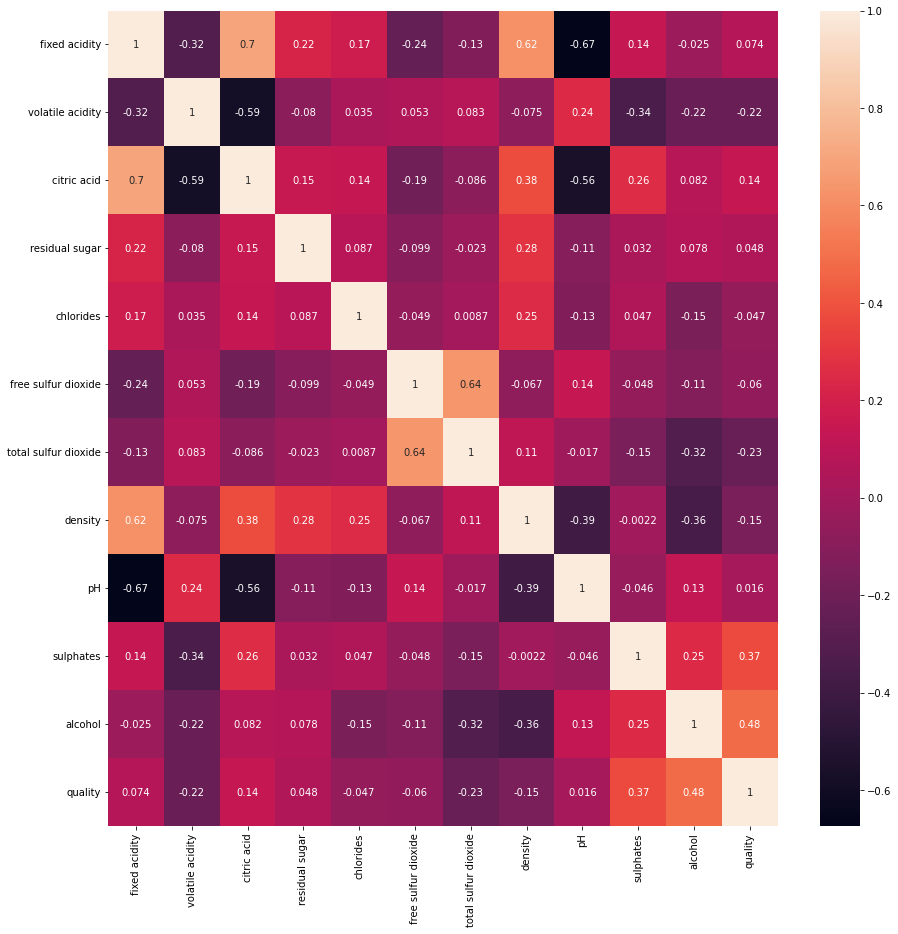

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train[features + ['quality']].corr(),annot=True)
plt.show()

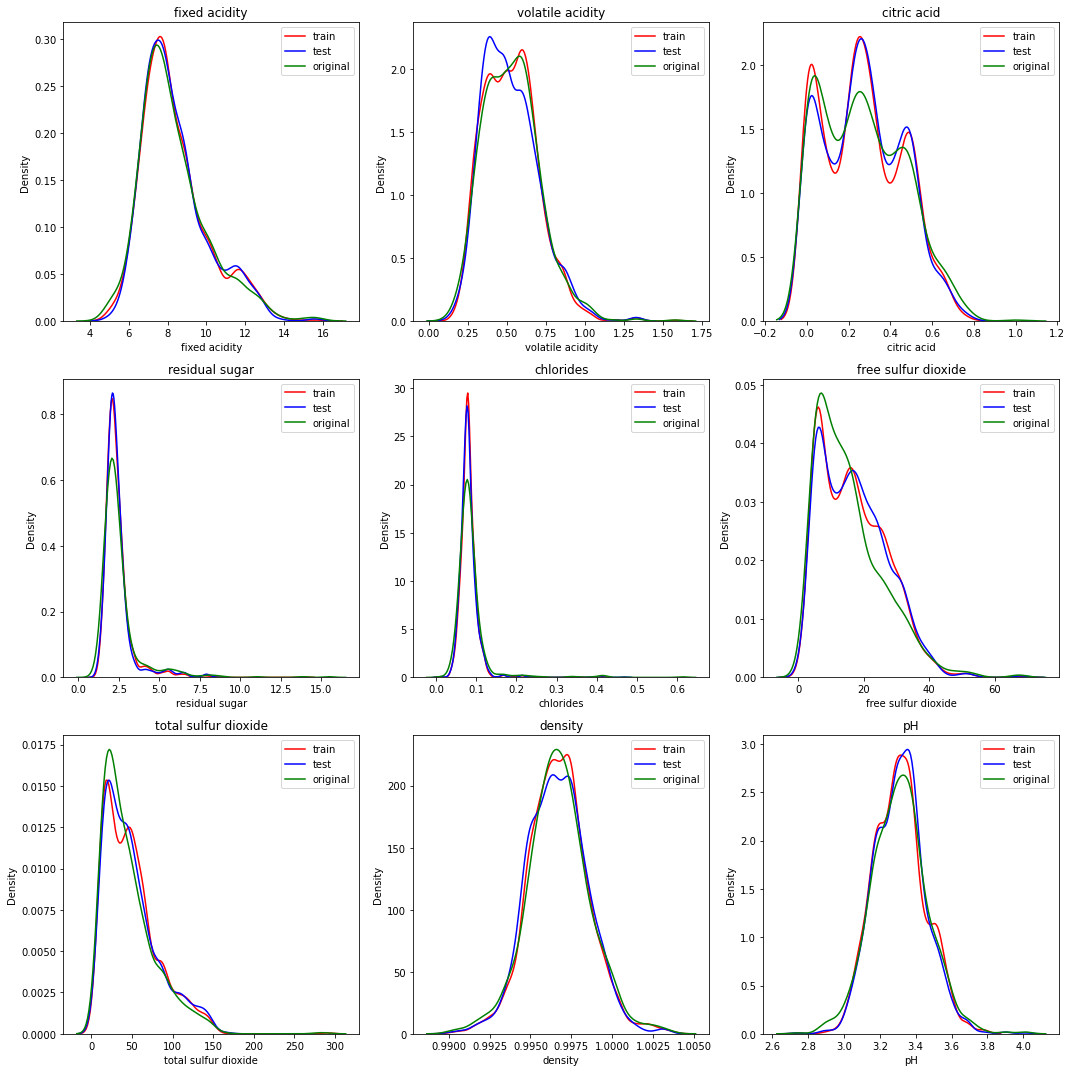

In [8]:
fig, axes = plt.subplots(nrows=int((len(features)/3)), ncols=3, figsize=(15, 15))
for ax, f in zip(axes.flat, features):
    sns.kdeplot(df_train[f], color='r', label='train', ax=ax)
    sns.kdeplot(df_test[f], color='b', label='test', ax=ax)
    sns.kdeplot(df_original[f], color='g', label='original', ax=ax)
    ax.set_title(f)
    ax.legend()
plt.tight_layout()
plt.show()

In [9]:
df_train.quality.value_counts()

5    839
6    778
7    333
4     55
8     39
3     12
Name: quality, dtype: int64

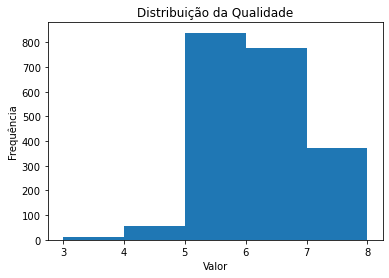

In [10]:
plt.hist(df_train.quality, bins=5)
plt.title("Distribuição da Qualidade")
plt.xlabel("Valor")
plt.ylabel("Frequência")
plt.show()

Add orginal dataset para aumentar robustez do dataset de treino

In [11]:
df_original.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [12]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [13]:
df_original.drop(columns = 'Id', inplace=True)

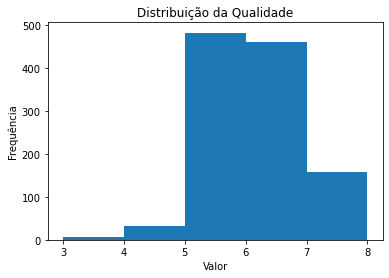

In [14]:
plt.hist(df_original.quality, bins=5)
plt.title("Distribuição da Qualidade")
plt.xlabel("Valor")
plt.ylabel("Frequência")
plt.show()

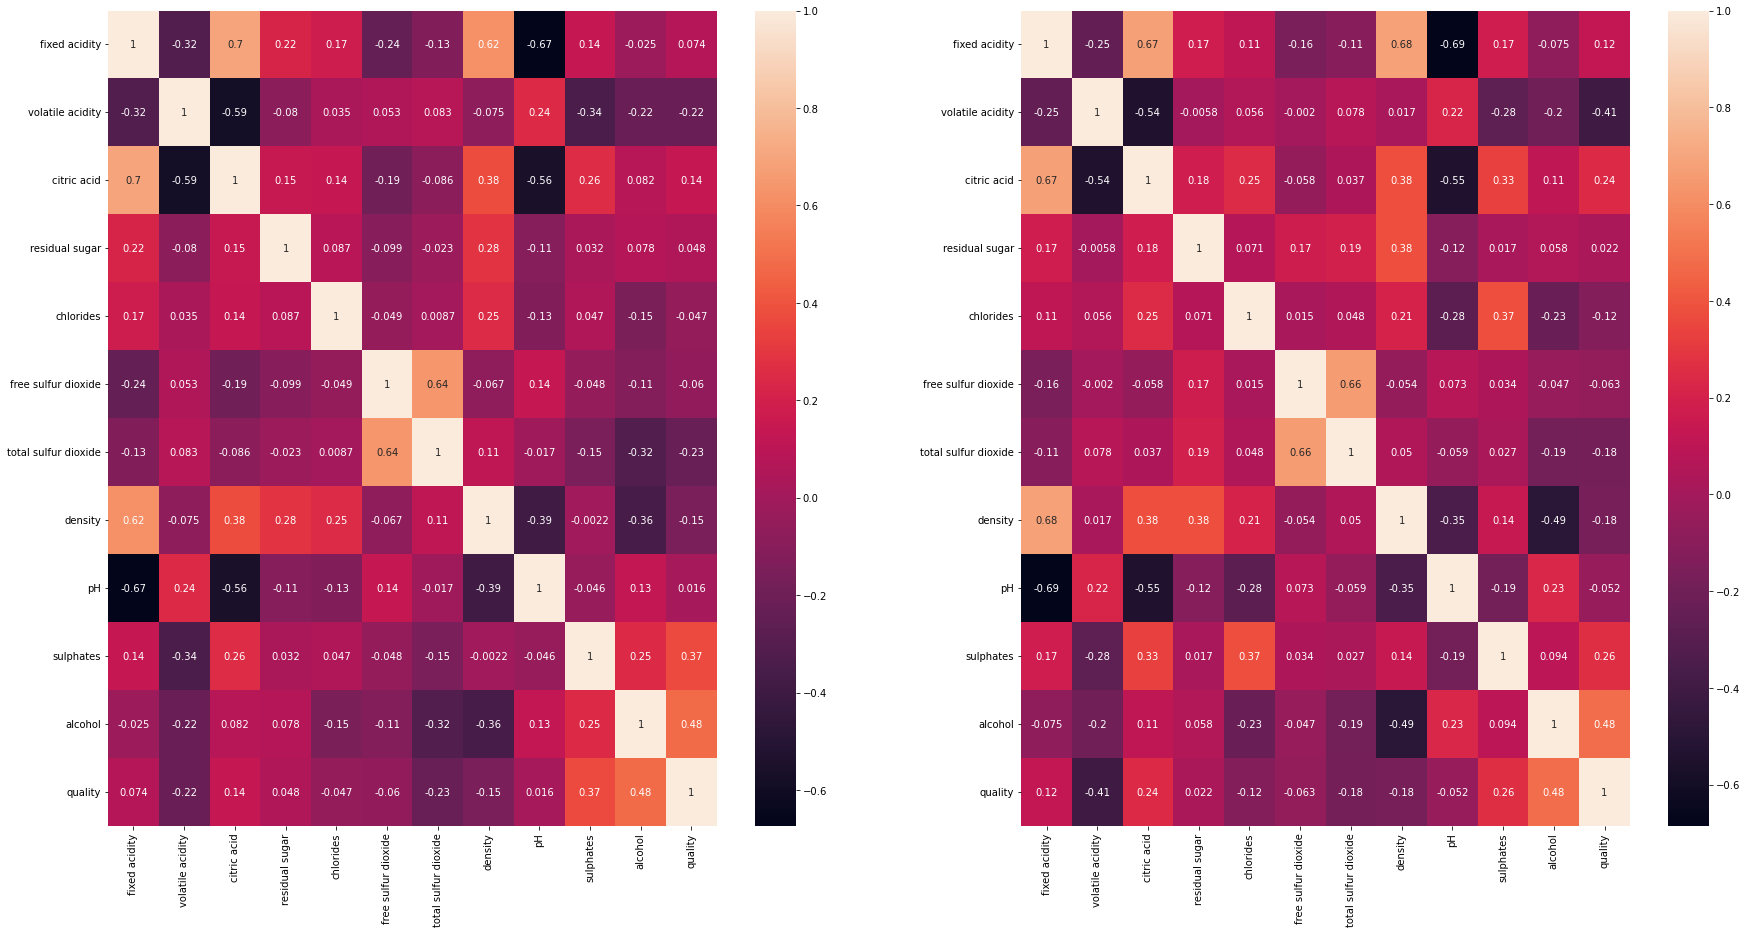

<Figure size 1080x1080 with 0 Axes>

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))
plt.figure(figsize=(15,15))
sns.heatmap(df_train[features + ['quality']].corr(),annot=True, ax=axes[0])
sns.heatmap(df_original[features + ['quality']].corr(),annot=True, ax=axes[1])
plt.show()

In [16]:
train = pd.concat([df_train, df_original]).reset_index(drop=True)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3199 non-null   float64
 1   volatile acidity      3199 non-null   float64
 2   citric acid           3199 non-null   float64
 3   residual sugar        3199 non-null   float64
 4   chlorides             3199 non-null   float64
 5   free sulfur dioxide   3199 non-null   float64
 6   total sulfur dioxide  3199 non-null   float64
 7   density               3199 non-null   float64
 8   pH                    3199 non-null   float64
 9   sulphates             3199 non-null   float64
 10  alcohol               3199 non-null   float64
 11  quality               3199 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 300.0 KB


In [18]:
robustS = RobustScaler()
train[features] = robustS.fit_transform(train[features])
df_original[features] = robustS.fit_transform(df_original[features])
df_train[features] = robustS.fit_transform(df_train[features])
df_test[features] = robustS.transform(df_test[features])
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.05,-0.08,0.424242,0.000000,-0.315789,0.9375,-0.071429,-0.441441,0.105263,0.882353,1.2500,6
1,0.70,-0.88,1.454545,0.142857,0.684211,0.9375,0.595238,0.828829,0.052632,0.294118,1.6875,6
2,-0.40,-0.04,-0.666667,-0.142857,-1.052632,-0.7500,-0.714286,-0.045045,1.105263,0.647059,0.7500,7
3,0.10,1.40,-0.090909,0.571429,0.263158,-0.2500,0.547619,0.270270,-0.578947,-0.529412,-0.1875,5
4,0.30,-0.64,0.151515,0.142857,0.000000,-0.3125,0.071429,-1.018018,-0.578947,4.352941,-0.3750,6


Apesar de concatenar os dois datasets, continua desbalanceado

In [19]:
target = 'quality'

trn_indep = train.drop([target], axis=1)
trn_dep = train.quality - 3

Optuna é uma biblioteca para otimização de hiperparâmetros. Ele fornece uma maneira simples e eficiente de realizar o ajuste de hiperparâmetros para modelos

In [20]:
rskf = RepeatedStratifiedKFold(random_state = 42)
skf = StratifiedKFold(3,shuffle=True, random_state=42)

In [21]:
models = []
preds = []
scores = []

def armazenaInfos(model):
    if score > 0.4:
        preds.append(model.predict(df_test[features]))
        scores.append(score)
        models.append(model)

In [23]:
optuna_param = True

## XGB

In [22]:
indep = trn_indep
dep = trn_dep
def objective(trial):
    params_optuna = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
            'gamma': trial.suggest_float('gamma', 0.01, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 1.0),
            'objective' : " multi:softmax",
            'tree_method': "gpu_hist",
        }
    
    for train_index, test_index in skf.split(indep, dep):
        X_train, X_valid = indep.iloc[train_index], indep.iloc[test_index]
        y_train, y_valid = dep.iloc[train_index], dep.iloc[test_index]
        
        model = XGBClassifier(**params_optuna)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid) + 3
        accuracy = accuracy_score(y_valid, y_pred)

    return accuracy
if oputna_param:
    study = optuna.create_study(direction='maximize')

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=100)

    print("Best hyperparameters: ", study.best_params)

[I 2023-02-01 22:20:19,910] A new study created in memory with name: no-name-26a44f5e-9830-4e54-a07c-5fefe0a4f31c


Best hyperparameters:  {'max_depth': 6, 'learning_rate': 0.9970487344222865, 'n_estimators': 1693, 'min_child_weight': 49, 'gamma': 0.7460212049417572, 'subsample': 0.6107924720234726, 'colsample_bytree': 0.8789116352184247, 'reg_alpha': 0.9831314011779511, 'reg_lambda': 0.5984821743359146}


In [24]:
xgb_params = {'max_depth': 6, 'learning_rate': 0.9970487344222865, 'n_estimators': 1693, 'min_child_weight': 49, 'gamma': 0.7460212049417572, 'subsample': 0.6107924720234726, 'colsample_bytree': 0.8789116352184247, 'reg_alpha': 0.9831314011779511, 'reg_lambda': 0.5984821743359146}
xgb_params['tree_method'] = 'gpu_hist'
xgb_params['eval_metric'] = 'auc'
xgb_params

{'max_depth': 6,
 'learning_rate': 0.9970487344222865,
 'n_estimators': 1693,
 'min_child_weight': 49,
 'gamma': 0.7460212049417572,
 'subsample': 0.6107924720234726,
 'colsample_bytree': 0.8789116352184247,
 'reg_alpha': 0.9831314011779511,
 'reg_lambda': 0.5984821743359146,
 'tree_method': 'gpu_hist',
 'eval_metric': 'auc'}

In [25]:
for train_index, test_index in rskf.split(trn_indep, trn_dep):
    X_train, X_valid = trn_indep.iloc[train_index], trn_indep.iloc[test_index]
    y_train, y_valid = trn_dep.iloc[train_index], trn_dep.iloc[test_index]

    XGBmodel = XGBClassifier(**xgb_params)

    XGBmodel.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], verbose = 100)

    pred = XGBmodel.predict(X_valid)
    score = cohen_kappa_score(y_valid, pred)

    armazenaInfos(XGBmodel)

[0]	validation_0-auc:0.73994
[100]	validation_0-auc:0.75475
[200]	validation_0-auc:0.74849
[300]	validation_0-auc:0.74446
[400]	validation_0-auc:0.74758
[500]	validation_0-auc:0.73675
[600]	validation_0-auc:0.73503
[700]	validation_0-auc:0.74030
[800]	validation_0-auc:0.73552
[900]	validation_0-auc:0.73533
[1000]	validation_0-auc:0.73409
[1100]	validation_0-auc:0.73687
[1200]	validation_0-auc:0.73225
[1300]	validation_0-auc:0.72883
[1400]	validation_0-auc:0.73080
[1500]	validation_0-auc:0.73101
[1600]	validation_0-auc:0.73061
[1692]	validation_0-auc:0.73317
[0]	validation_0-auc:0.71339
[100]	validation_0-auc:0.72778
[200]	validation_0-auc:0.72522
[300]	validation_0-auc:0.71513
[400]	validation_0-auc:0.71510
[500]	validation_0-auc:0.71171
[600]	validation_0-auc:0.70803
[700]	validation_0-auc:0.70847
[800]	validation_0-auc:0.70946
[900]	validation_0-auc:0.70317
[1000]	validation_0-auc:0.70580
[1100]	validation_0-auc:0.70133
[1200]	validation_0-auc:0.70365
[1300]	validation_0-auc:0.69435


# Light GBM

In [28]:
def objective(trial):
    params_optuna = {
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0,),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0,),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100, step=5),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_iterations':trial.suggest_int('num_iterations', 100, 1000, step=50),
        'objective' : "multiclass",
        'metric' :'multi_logloss'
    }
    
    for train_index, test_index in skf.split(indep, dep):
        X_train, X_valid = indep.iloc[train_index], indep.iloc[test_index]
        y_train, y_valid = dep.iloc[train_index], dep.iloc[test_index]
        
        model = LGBMClassifier(**params_optuna)
        model.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], verbose = 200, early_stopping_rounds = 200)

        y_pred = model.predict(X_valid) + 3
        accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

if optuna_param:
    study = optuna.create_study(direction='maximize')

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=100)

    print("Best hyperparameters: ", study.best_params)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9487696267069725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9487696267069725
[LightGBM] [Warning] lambda_l1 is set=0.35385524149661873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35385524149661873
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.1560018837776913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1560018837776913
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.01809
[LightGBM] [Warning] bagging_fraction is set=0.9487696267069725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9487696267069725
[LightGBM] [Warning] lambda_l1 is set=0.3538

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0251
[LightGBM] [Warning] bagging_fraction is set=0.9487696267069725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9487696267069725
[LightGBM] [Warning] lambda_l1 is set=0.35385524149661873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35385524149661873
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.1560018837776913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1560018837776913
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04238
[LightGBM] [Warning] bagging_fraction is set=0.45042518088845773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45042518088845773
[LightGBM] [Warning] lambda_l1 is set=0.35623083825912427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35623083825912427
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6129645052896032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129645052896032
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.10468
[LightGBM] [Warning] bagging_fraction is set=0.45042518088845773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45042518088845773
[LightGBM] [Warning] lambda_l1 is set=0.35623083825912427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35623083825912427
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6129645052896032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129645052896032
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.11054
[LightGBM] [Warning] bagging_fraction is set=0.45042518088845773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45042518088845773
[LightGBM] [Warning] lambda_l1 is set=0.35623083825912427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35623083825912427
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6129645052896032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129645052896032
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.11961
[LightGBM] [Warning] bagging_fraction is set=0.4966219585370161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4966219585370161
[LightGBM] [Warning] lambda_l1 is set=0.7036553234447096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7036553234447096
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5317991698026541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5317991698026541
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.979655


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.4966219585370161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4966219585370161
[LightGBM] [Warning] lambda_l1 is set=0.7036553234447096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7036553234447096
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5317991698026541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5317991698026541
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[200]	valid_0's multi_logloss: 0.99173
[LightGBM] [Warning] bagging_fraction is set=0.4966219585370161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4966219585370161
[LightGBM] [Warning] lambda_l1 is set=0.703655

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.987457
[LightGBM] [Warning] bagging_fraction is set=0.3195783075905399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3195783075905399
[LightGBM] [Warning] lambda_l1 is set=0.43302740573643284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43302740573643284
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8924829648639598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8924829648639598
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03048
[LightGBM] [Warning] bagging_fraction is set=0.3195783075905399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3195783075905399
[LightGBM] [Warning] lambda_l1 is set=0.43302740573643284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43302740573643284
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8924829648639598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8924829648639598
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05085
[LightGBM] [Warning] bagging_fraction is set=0.3195783075905399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3195783075905399
[LightGBM] [Warning] lambda_l1 is set=0.43302740573643284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43302740573643284
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8924829648639598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8924829648639598
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05998


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.14528945295675993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14528945295675993
[LightGBM] [Warning] lambda_l1 is set=0.8945803245239491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945803245239491
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.21160792401365935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21160792401365935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[200]	valid_0's multi_logloss: 0.980413
[400]	valid_0's multi_logloss: 0.984953


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.14528945295675993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14528945295675993
[LightGBM] [Warning] lambda_l1 is set=0.8945803245239491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945803245239491
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.21160792401365935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21160792401365935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[200]	valid_0's multi_logloss: 0.995853
[400]	valid_0's multi_logloss: 1.01724


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.14528945295675993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14528945295675993
[LightGBM] [Warning] lambda_l1 is set=0.8945803245239491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8945803245239491
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.21160792401365935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21160792401365935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[200]	valid_0's multi_logloss: 1.00342
[400]	valid_0's multi_logloss: 1.002
[LightGBM] [Warning] bagging_fraction is set=0.7045346717643896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045346717643896
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.00835


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7045346717643896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045346717643896
[LightGBM] [Warning] lambda_l1 is set=0.23329348861694332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23329348861694332
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7081025444984117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7081025444984117
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[200]	valid_0's multi_logloss: 1.01877


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7045346717643896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045346717643896
[LightGBM] [Warning] lambda_l1 is set=0.23329348861694332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23329348861694332
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.7081025444984117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7081025444984117
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[200]	valid_0's multi_logloss: 1.0283
[LightGBM] [Warning] bagging_fraction is set=0.8974518994437182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8974518994437182
[LightGBM] [Warning] lambda_l1 is set=0.0288929

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.37679
[LightGBM] [Warning] bagging_fraction is set=0.8974518994437182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8974518994437182
[LightGBM] [Warning] lambda_l1 is set=0.02889298984359534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02889298984359534
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.9136556672257254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9136556672257254
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.39278
[LightGBM] [Warning] bagging_fraction is set=0.8974518994437182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8974518994437182
[LightGBM] [Warning] lambda_l1 is set=0.02889298984359534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02889298984359534
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.9136556672257254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9136556672257254
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.36152
[LightGBM] [Warning] bagging_fraction is set=0.23720278582146387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23720278582146387
[LightGBM] [Warning] lambda_l1 is set=0.8795447561378584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8795447561378584
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.9255669660698415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255669660698415
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.12716
[LightGBM] [Warning] bagging_fraction is set=0.23720278582146387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23720278582146387
[LightGBM] [Warning] lambda_l1 is set=0.8795447561378584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8795447561378584
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.9255669660698415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255669660698415
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.1802
[LightGBM] [Warning] bagging_fraction is set=0.23720278582146387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23720278582146387
[LightGBM] [Warning] lambda_l1 is set=0.8795447561378584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8795447561378584
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.9255669660698415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255669660698415
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.18183
[LightGBM] [Warning] bagging_fraction is set=0.812808904827716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812808904827716
[LightGBM] [Warning] lambda_l1 is set=0.34584110306314286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34584110306314286
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.9023321676238576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9023321676238576
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_

[LightGBM] [Warning] bagging_fraction is set=0.812808904827716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812808904827716
[LightGBM] [Warning] lambda_l1 is set=0.34584110306314286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34584110306314286
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.9023321676238576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9023321676238576
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.812808904827716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812808904827716
[LightGBM] [Warning] lambda_l1 is set=0.34584110306314286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34584110306314286
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.9023321676238576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9023321676238576
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.23714699315514182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23714699315514182
[LightGBM] [Warning] lambda_l1 is set=0.5785191539962679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5785191539962679
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.327685236105054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.327685236105054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[200]	valid_0's multi_logloss: 1.34136
[LightGBM] [Warning] bagging_fraction is set=0.23714699315514182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23714699315514182
[LightGBM] [Warning] lambda_l1 is set=0.578519

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.32962
[LightGBM] [Warning] bagging_fraction is set=0.23714699315514182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23714699315514182
[LightGBM] [Warning] lambda_l1 is set=0.5785191539962679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5785191539962679
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.327685236105054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.327685236105054
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.32044
[LightGBM] [Warning] bagging_fraction is set=0.9782460522402455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9782460522402455
[LightGBM] [Warning] lambda_l1 is set=0.6072727649558485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6072727649558485
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.12140256562395264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12140256562395264
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02124
[LightGBM] [Warning] bagging_fraction is set=0.9782460522402455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9782460522402455
[LightGBM] [Warning] lambda_l1 is set=0.6072727649558485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6072727649558485
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.12140256562395264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12140256562395264
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02752
[LightGBM] [Warning] bagging_fraction is set=0.9782460522402455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9782460522402455
[LightGBM] [Warning] lambda_l1 is set=0.6072727649558485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6072727649558485
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.12140256562395264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12140256562395264
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02379


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6336539918844459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336539918844459
[LightGBM] [Warning] lambda_l1 is set=0.6966077133381353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6966077133381353
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.4085003132476783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4085003132476783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.00164
[400]	valid_0's multi_logloss: 0.984606


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6336539918844459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336539918844459
[LightGBM] [Warning] lambda_l1 is set=0.6966077133381353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6966077133381353
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.4085003132476783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4085003132476783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.00476
[400]	valid_0's multi_logloss: 0.990965


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6336539918844459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336539918844459
[LightGBM] [Warning] lambda_l1 is set=0.6966077133381353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6966077133381353
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.4085003132476783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4085003132476783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 0.99987
[400]	valid_0's multi_logloss: 0.987001


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5156251214254369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5156251214254369
[LightGBM] [Warning] lambda_l1 is set=0.716665019615986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.716665019615986
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.45319827899570103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45319827899570103
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 1.02499
[LightGBM] [Warning] bagging_fraction is set=0.5156251214254369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5156251214254369
[LightGBM] [Warning] lambda_l1 is set=0.716665

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04239
[LightGBM] [Warning] bagging_fraction is set=0.5156251214254369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5156251214254369
[LightGBM] [Warning] lambda_l1 is set=0.716665019615986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.716665019615986
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.45319827899570103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45319827899570103
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.057
[LightGBM] [Warning] bagging_fraction is set=0.7610926232957262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7610926232957262
[LightGBM] [Warning] lambda_l1 is set=0.5165299591488764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5165299591488764
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2832048580704216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2832048580704216
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.998176


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7610926232957262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7610926232957262
[LightGBM] [Warning] lambda_l1 is set=0.5165299591488764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5165299591488764
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2832048580704216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2832048580704216
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 1.00855


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7610926232957262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7610926232957262
[LightGBM] [Warning] lambda_l1 is set=0.5165299591488764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5165299591488764
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2832048580704216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2832048580704216
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 1.00292


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6132780794785719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6132780794785719
[LightGBM] [Warning] lambda_l1 is set=0.7297002885498947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7297002885498947
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.10400597634134118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10400597634134118
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 1.09595


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6132780794785719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6132780794785719
[LightGBM] [Warning] lambda_l1 is set=0.7297002885498947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7297002885498947
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.10400597634134118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10400597634134118
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 1.10133


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6132780794785719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6132780794785719
[LightGBM] [Warning] lambda_l1 is set=0.7297002885498947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7297002885498947
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.10400597634134118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10400597634134118
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 1.0982


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9918029717900145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9918029717900145
[LightGBM] [Warning] lambda_l1 is set=0.9241854444235007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9241854444235007
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5064584537306323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5064584537306323
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[200]	valid_0's multi_logloss: 1.01291
[LightGBM] [Warning] bagging_fraction is set=0.9918029717900145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9918029717900145
[LightGBM] [Warning] lambda_l1 is set=0.92418544

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02639
[LightGBM] [Warning] bagging_fraction is set=0.9918029717900145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9918029717900145
[LightGBM] [Warning] lambda_l1 is set=0.9241854444235007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9241854444235007
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5064584537306323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5064584537306323
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02656
[LightGBM] [Warning] bagging_fraction is set=0.44023478329568044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44023478329568044
[LightGBM] [Warning] lambda_l1 is set=0.9949686960156805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9949686960156805
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3665285990069087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3665285990069087
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0282
[LightGBM] [Warning] bagging_fraction is set=0.44023478329568044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44023478329568044
[LightGBM] [Warning] lambda_l1 is set=0.9949686960156805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9949686960156805
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3665285990069087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3665285990069087
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04746
[LightGBM] [Warning] bagging_fraction is set=0.44023478329568044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44023478329568044
[LightGBM] [Warning] lambda_l1 is set=0.9949686960156805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9949686960156805
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3665285990069087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3665285990069087
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04686
[LightGBM] [Warning] bagging_fraction is set=0.8409591562471779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8409591562471779
[LightGBM] [Warning] lambda_l1 is set=0.4639320977099316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4639320977099316
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.24668052632962822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24668052632962822
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05497
[LightGBM] [Warning] bagging_fraction is set=0.8409591562471779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8409591562471779
[LightGBM] [Warning] lambda_l1 is set=0.4639320977099316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4639320977099316
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.24668052632962822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24668052632962822
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04997
[LightGBM] [Warning] bagging_fraction is set=0.8409591562471779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8409591562471779
[LightGBM] [Warning] lambda_l1 is set=0.4639320977099316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4639320977099316
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.24668052632962822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24668052632962822
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05237
[LightGBM] [Warning] bagging_fraction is set=0.6897277491291904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6897277491291904
[LightGBM] [Warning] lambda_l1 is set=0.24311767071291535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24311767071291535
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5863318032756131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5863318032756131
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.98402


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6897277491291904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6897277491291904
[LightGBM] [Warning] lambda_l1 is set=0.24311767071291535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24311767071291535
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5863318032756131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5863318032756131
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 1.00036


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6897277491291904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6897277491291904
[LightGBM] [Warning] lambda_l1 is set=0.24311767071291535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24311767071291535
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5863318032756131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5863318032756131
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 0.99969


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.02493
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0185
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03453


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5874757024001966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5874757024001966
[LightGBM] [Warning] lambda_l1 is set=0.6026103162147841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6026103162147841
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.2088758356015249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2088758356015249
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5874757024001966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5874757024001966
[LightGBM] [Warning] lambda_l1 is set=0.6026103162147841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6026103162147841
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.2088758356015249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2088758356015249
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5874757024001966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5874757024001966
[LightGBM] [Warning] lambda_l1 is set=0.6026103162147841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6026103162147841
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.2088758356015249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2088758356015249
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5282952301746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5282952301746235
[LightGBM] [Warning] lambda_l1 is set=0.7824505349102189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7824505349102189
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.44652952121125705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44652952121125705
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.01376
[LightGBM] [Warning] bagging_fraction is set=0.5282952301746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5282952301746235
[LightGBM] [Warning] lambda_l1 is set=0.7824

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01172


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5282952301746235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5282952301746235
[LightGBM] [Warning] lambda_l1 is set=0.7824505349102189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7824505349102189
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.44652952121125705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44652952121125705
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.02042


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7064369971909891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7064369971909891
[LightGBM] [Warning] lambda_l1 is set=0.650006923729878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.650006923729878
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.3624935261427983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3624935261427983
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[200]	valid_0's multi_logloss: 0.987538


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7064369971909891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7064369971909891
[LightGBM] [Warning] lambda_l1 is set=0.650006923729878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.650006923729878
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.3624935261427983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3624935261427983
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[200]	valid_0's multi_logloss: 0.992523


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7064369971909891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7064369971909891
[LightGBM] [Warning] lambda_l1 is set=0.650006923729878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.650006923729878
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.3624935261427983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3624935261427983
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[200]	valid_0's multi_logloss: 1.0051


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8953936721350335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8953936721350335
[LightGBM] [Warning] lambda_l1 is set=0.7655603398689496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7655603398689496
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5082071465751564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082071465751564
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 1.02387
[LightGBM] [Warning] bagging_fraction is set=0.8953936721350335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8953936721350335
[LightGBM] [Warning] lambda_l1 is set=0.7655603

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03197
[LightGBM] [Warning] bagging_fraction is set=0.8953936721350335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8953936721350335
[LightGBM] [Warning] lambda_l1 is set=0.7655603398689496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7655603398689496
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5082071465751564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082071465751564
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03328


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.4078417790762002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4078417790762002
[LightGBM] [Warning] lambda_l1 is set=0.5167014259768535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5167014259768535
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.2991536748550335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2991536748550335
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[200]	valid_0's multi_logloss: 1.01995
[LightGBM] [Warning] bagging_fraction is set=0.4078417790762002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4078417790762002
[LightGBM] [Warning] lambda_l1 is set=0.51670142

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02335
[LightGBM] [Warning] bagging_fraction is set=0.4078417790762002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4078417790762002
[LightGBM] [Warning] lambda_l1 is set=0.5167014259768535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5167014259768535
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.2991536748550335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2991536748550335
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02735


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5365198322296921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5365198322296921
[LightGBM] [Warning] lambda_l1 is set=0.6487654549978612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6487654549978612
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1635010862136171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1635010862136171
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.979987


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5365198322296921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5365198322296921
[LightGBM] [Warning] lambda_l1 is set=0.6487654549978612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6487654549978612
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1635010862136171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1635010862136171
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.988354


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5365198322296921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5365198322296921
[LightGBM] [Warning] lambda_l1 is set=0.6487654549978612, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6487654549978612
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.1635010862136171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1635010862136171
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.994484


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5998008035401068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5998008035401068
[LightGBM] [Warning] lambda_l1 is set=0.8107786331233477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8107786331233477
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.21869300388149604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21869300388149604
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[200]	valid_0's multi_logloss: 1.04444
[LightGBM] [Warning] bagging_fraction is set=0.5998008035401068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5998008035401068
[LightGBM] [Warning] lambda_l1 is set=0.810778

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05338
[LightGBM] [Warning] bagging_fraction is set=0.5998008035401068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5998008035401068
[LightGBM] [Warning] lambda_l1 is set=0.8107786331233477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8107786331233477
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.21869300388149604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21869300388149604
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.07379
[LightGBM] [Warning] bagging_fraction is set=0.7685543240519253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685543240519253
[LightGBM] [Warning] lambda_l1 is set=0.5539504117500992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5539504117500992
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.297181333764693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.297181333764693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.982026
[LightGBM] [Warning] bagging_fraction is set=0.7685543240519253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685543240519253
[LightGBM] [Warning] lambda_l1 is set=0.5539504117500992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5539504117500992
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.297181333764693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.297181333764693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.993636
[LightGBM] [Warning] bagging_fraction is set=0.7685543240519253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7685543240519253
[LightGBM] [Warning] lambda_l1 is set=0.5539504117500992, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5539504117500992
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.297181333764693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.297181333764693
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.986859
[LightGBM] [Warning] bagging_fraction is set=0.4921626271726776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4921626271726776
[LightGBM] [Warning] lambda_l1 is set=0.6765028935253833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6765028935253833
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.38498200416772144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38498200416772144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.990302
[LightGBM] [Warning] bagging_fraction is set=0.4921626271726776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4921626271726776
[LightGBM] [Warning] lambda_l1 is set=0.6765028935253833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6765028935253833
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.38498200416772144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38498200416772144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.998512


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.4921626271726776, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4921626271726776
[LightGBM] [Warning] lambda_l1 is set=0.6765028935253833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6765028935253833
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.38498200416772144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38498200416772144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.01837


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.4038345714178198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4038345714178198
[LightGBM] [Warning] lambda_l1 is set=0.43373366708296623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43373366708296623
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6925990494991117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6925990494991117
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[200]	valid_0's multi_logloss: 1.03624


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.4038345714178198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4038345714178198
[LightGBM] [Warning] lambda_l1 is set=0.43373366708296623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43373366708296623
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6925990494991117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6925990494991117
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[200]	valid_0's multi_logloss: 1.05882
[LightGBM] [Warning] bagging_fraction is set=0.4038345714178198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4038345714178198
[LightGBM] [Warning] lambda_l1 is set=0.433733

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05344


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.4736032983253737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4736032983253737
[LightGBM] [Warning] lambda_l1 is set=0.5553411566165531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5553411566165531
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5648129911945291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5648129911945291
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.04796
[LightGBM] [Warning] bagging_fraction is set=0.4736032983253737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4736032983253737
[LightGBM] [Warning] lambda_l1 is set=0.55534115

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03235
[LightGBM] [Warning] bagging_fraction is set=0.4736032983253737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4736032983253737
[LightGBM] [Warning] lambda_l1 is set=0.5553411566165531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5553411566165531
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5648129911945291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5648129911945291
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05215
[LightGBM] [Warning] bagging_fraction is set=0.6980958665372357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6980958665372357
[LightGBM] [Warning] lambda_l1 is set=0.3041139439070302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3041139439070302
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6507464536472906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6507464536472906
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.980899


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6980958665372357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6980958665372357
[LightGBM] [Warning] lambda_l1 is set=0.3041139439070302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3041139439070302
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6507464536472906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6507464536472906
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[200]	valid_0's multi_logloss: 0.994628


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6980958665372357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6980958665372357
[LightGBM] [Warning] lambda_l1 is set=0.3041139439070302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3041139439070302
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6507464536472906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6507464536472906
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[200]	valid_0's multi_logloss: 0.990386


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6632065886554455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6632065886554455
[LightGBM] [Warning] lambda_l1 is set=0.2377665853597794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2377665853597794
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7326548100307294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7326548100307294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[200]	valid_0's multi_logloss: 1.04454
[LightGBM] [Warning] bagging_fraction is set=0.6632065886554455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6632065886554455
[LightGBM] [Warning] lambda_l1 is set=0.23776658

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05669
[LightGBM] [Warning] bagging_fraction is set=0.6632065886554455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6632065886554455
[LightGBM] [Warning] lambda_l1 is set=0.2377665853597794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2377665853597794
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7326548100307294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7326548100307294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04937
[LightGBM] [Warning] bagging_fraction is set=0.5434545557614738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5434545557614738
[LightGBM] [Warning] lambda_l1 is set=0.3987367777295586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3987367777295586
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.7902973562472088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7902973562472088
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.21395
[LightGBM] [Warning] bagging_fraction is set=0.5434545557614738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5434545557614738
[LightGBM] [Warning] lambda_l1 is set=0.3987367777295586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3987367777295586
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.7902973562472088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7902973562472088
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.20064
[LightGBM] [Warning] bagging_fraction is set=0.5434545557614738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5434545557614738
[LightGBM] [Warning] lambda_l1 is set=0.3987367777295586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3987367777295586
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.7902973562472088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7902973562472088
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.20866
[LightGBM] [Warning] bagging_fraction is set=0.5786365553047028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5786365553047028
[LightGBM] [Warning] lambda_l1 is set=0.4693212275059065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4693212275059065
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5940308035550235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5940308035550235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.981022


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5786365553047028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5786365553047028
[LightGBM] [Warning] lambda_l1 is set=0.4693212275059065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4693212275059065
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5940308035550235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5940308035550235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 0.998881


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5786365553047028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5786365553047028
[LightGBM] [Warning] lambda_l1 is set=0.4693212275059065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4693212275059065
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5940308035550235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5940308035550235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 0.979651


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6526245249344165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6526245249344165
[LightGBM] [Warning] lambda_l1 is set=0.17299440928235293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17299440928235293
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5243006222747552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5243006222747552
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[200]	valid_0's multi_logloss: 1.05137
[LightGBM] [Warning] bagging_fraction is set=0.6526245249344165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6526245249344165
[LightGBM] [Warning] lambda_l1 is set=0.172994

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06498
[LightGBM] [Warning] bagging_fraction is set=0.6526245249344165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6526245249344165
[LightGBM] [Warning] lambda_l1 is set=0.17299440928235293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17299440928235293
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.5243006222747552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5243006222747552
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06311
[LightGBM] [Warning] bagging_fraction is set=0.7473908893727983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7473908893727983
[LightGBM] [Warning] lambda_l1 is set=0.3786265758849431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3786265758849431
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.6579410023852332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579410023852332
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.088
[LightGBM] [Warning] bagging_fraction is set=0.7473908893727983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7473908893727983
[LightGBM] [Warning] lambda_l1 is set=0.3786265758849431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3786265758849431
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.6579410023852332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579410023852332
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.08579
[LightGBM] [Warning] bagging_fraction is set=0.7473908893727983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7473908893727983
[LightGBM] [Warning] lambda_l1 is set=0.3786265758849431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3786265758849431
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.6579410023852332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579410023852332
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.08713
[LightGBM] [Warning] bagging_fraction is set=0.8104947049542152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104947049542152
[LightGBM] [Warning] lambda_l1 is set=0.11441854763922288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11441854763922288
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.4547465375212393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4547465375212393
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03912
[LightGBM] [Warning] bagging_fraction is set=0.8104947049542152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104947049542152
[LightGBM] [Warning] lambda_l1 is set=0.11441854763922288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11441854763922288
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.4547465375212393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4547465375212393
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03749
[LightGBM] [Warning] bagging_fraction is set=0.8104947049542152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8104947049542152
[LightGBM] [Warning] lambda_l1 is set=0.11441854763922288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11441854763922288
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.4547465375212393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4547465375212393
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04645
[LightGBM] [Warning] bagging_fraction is set=0.9312414640491201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312414640491201
[LightGBM] [Warning] lambda_l1 is set=0.33399305971354565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33399305971354565
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.5469651777653977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469651777653977
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.08696
[LightGBM] [Warning] bagging_fraction is set=0.9312414640491201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312414640491201
[LightGBM] [Warning] lambda_l1 is set=0.33399305971354565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33399305971354565
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.5469651777653977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469651777653977
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.10047
[LightGBM] [Warning] bagging_fraction is set=0.9312414640491201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312414640491201
[LightGBM] [Warning] lambda_l1 is set=0.33399305971354565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33399305971354565
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.5469651777653977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5469651777653977
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.09631
[LightGBM] [Warning] bagging_fraction is set=0.8514604139448043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514604139448043
[LightGBM] [Warning] lambda_l1 is set=0.4124164080445118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4124164080445118
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6272879771364297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6272879771364297
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.999582
[400]	valid_0's multi_logloss: 0.979795
[600]	valid_0's multi_logloss: 0.977155


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8514604139448043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514604139448043
[LightGBM] [Warning] lambda_l1 is set=0.4124164080445118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4124164080445118
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6272879771364297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6272879771364297
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 1.00983
[400]	valid_0's multi_logloss: 0.994356
[600]	valid_0's multi_logloss: 0.991304


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8514604139448043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8514604139448043
[LightGBM] [Warning] lambda_l1 is set=0.4124164080445118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4124164080445118
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.6272879771364297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6272879771364297
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 0.991419
[400]	valid_0's multi_logloss: 0.975987
[600]	valid_0's multi_logloss: 0.977543


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5712871537444334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5712871537444334
[LightGBM] [Warning] lambda_l1 is set=0.024301666590213544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024301666590213544
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.17656992297503193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17656992297503193
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[200]	valid_0's multi_logloss: 0.983992
[400]	valid_0's multi_logloss: 0.974486
[LightGBM] [Warning] bagging_fraction is set=0.5712871537444334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5712871537444334

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.995291
[400]	valid_0's multi_logloss: 0.986602


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5712871537444334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5712871537444334
[LightGBM] [Warning] lambda_l1 is set=0.024301666590213544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024301666590213544
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.17656992297503193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17656992297503193
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[200]	valid_0's multi_logloss: 0.994943
[400]	valid_0's multi_logloss: 0.988591


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9467406522867732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9467406522867732
[LightGBM] [Warning] lambda_l1 is set=0.02769192613742808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02769192613742808
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.981988534742569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981988534742569
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[200]	valid_0's multi_logloss: 1.35702
[LightGBM] [Warning] bagging_fraction is set=0.9467406522867732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9467406522867732
[LightGBM] [Warning] lambda_l1 is set=0.02769192

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.31675
[LightGBM] [Warning] bagging_fraction is set=0.9467406522867732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9467406522867732
[LightGBM] [Warning] lambda_l1 is set=0.02769192613742808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02769192613742808
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.981988534742569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981988534742569
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.33787
[LightGBM] [Warning] bagging_fraction is set=0.8923088724776337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8923088724776337
[LightGBM] [Warning] lambda_l1 is set=0.07749563872075371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07749563872075371
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7997142916608746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997142916608746
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.59708
[LightGBM] [Warning] bagging_fraction is set=0.8923088724776337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8923088724776337
[LightGBM] [Warning] lambda_l1 is set=0.07749563872075371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07749563872075371
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7997142916608746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997142916608746
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.59064
[LightGBM] [Warning] bagging_fraction is set=0.8923088724776337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8923088724776337
[LightGBM] [Warning] lambda_l1 is set=0.07749563872075371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07749563872075371
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7997142916608746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7997142916608746
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.57634
[LightGBM] [Warning] bagging_fraction is set=0.9934140020264143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9934140020264143
[LightGBM] [Warning] lambda_l1 is set=0.16564358063947415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16564358063947415
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8937529046227297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8937529046227297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.43471
[LightGBM] [Warning] bagging_fraction is set=0.9934140020264143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9934140020264143
[LightGBM] [Warning] lambda_l1 is set=0.16564358063947415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16564358063947415
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8937529046227297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8937529046227297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.42543
[LightGBM] [Warning] bagging_fraction is set=0.9934140020264143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9934140020264143
[LightGBM] [Warning] lambda_l1 is set=0.16564358063947415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16564358063947415
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.8937529046227297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8937529046227297
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.39569
[LightGBM] [Warning] bagging_fraction is set=0.9337905301078226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337905301078226
[LightGBM] [Warning] lambda_l1 is set=0.0011588902581668517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011588902581668517
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8190523651918471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8190523651918471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.3341
[LightGBM] [Warning] bagging_fraction is set=0.9337905301078226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337905301078226
[LightGBM] [Warning] lambda_l1 is set=0.0011588902581668517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011588902581668517
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8190523651918471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8190523651918471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.32705
[LightGBM] [Warning] bagging_fraction is set=0.9337905301078226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9337905301078226
[LightGBM] [Warning] lambda_l1 is set=0.0011588902581668517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011588902581668517
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8190523651918471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8190523651918471
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.33142
[LightGBM] [Warning] bagging_fraction is set=0.6282325494576311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282325494576311
[LightGBM] [Warning] lambda_l1 is set=0.3102743398738721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3102743398738721
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9435180480541261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9435180480541261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03048
[LightGBM] [Warning] bagging_fraction is set=0.6282325494576311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282325494576311
[LightGBM] [Warning] lambda_l1 is set=0.3102743398738721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3102743398738721
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9435180480541261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9435180480541261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05043
[LightGBM] [Warning] bagging_fraction is set=0.6282325494576311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282325494576311
[LightGBM] [Warning] lambda_l1 is set=0.3102743398738721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3102743398738721
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9435180480541261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9435180480541261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05651
[LightGBM] [Warning] bagging_fraction is set=0.8078298041927232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078298041927232
[LightGBM] [Warning] lambda_l1 is set=0.2817281451070834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2817281451070834
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.8393167849473093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8393167849473093
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06901
[LightGBM] [Warning] bagging_fraction is set=0.8078298041927232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078298041927232
[LightGBM] [Warning] lambda_l1 is set=0.2817281451070834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2817281451070834
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.8393167849473093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8393167849473093
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0686
[LightGBM] [Warning] bagging_fraction is set=0.8078298041927232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078298041927232
[LightGBM] [Warning] lambda_l1 is set=0.2817281451070834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2817281451070834
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.8393167849473093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8393167849473093
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.07313
[LightGBM] [Warning] bagging_fraction is set=0.7299439636511132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7299439636511132
[LightGBM] [Warning] lambda_l1 is set=0.3514496395254036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3514496395254036
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.735084759706693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735084759706693
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.99261
[400]	valid_0's multi_logloss: 0.976033


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7299439636511132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7299439636511132
[LightGBM] [Warning] lambda_l1 is set=0.3514496395254036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3514496395254036
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.735084759706693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735084759706693
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[200]	valid_0's multi_logloss: 0.998192
[400]	valid_0's multi_logloss: 0.987235


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7299439636511132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7299439636511132
[LightGBM] [Warning] lambda_l1 is set=0.3514496395254036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3514496395254036
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.735084759706693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735084759706693
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[200]	valid_0's multi_logloss: 0.988873
[400]	valid_0's multi_logloss: 0.97538


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7793301489942988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793301489942988
[LightGBM] [Warning] lambda_l1 is set=0.22335726117535049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22335726117535049
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8662613933739302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8662613933739302
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[200]	valid_0's multi_logloss: 1.16675
[LightGBM] [Warning] bagging_fraction is set=0.7793301489942988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793301489942988
[LightGBM] [Warning] lambda_l1 is set=0.223357

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.17479
[LightGBM] [Warning] bagging_fraction is set=0.7793301489942988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7793301489942988
[LightGBM] [Warning] lambda_l1 is set=0.22335726117535049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22335726117535049
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8662613933739302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8662613933739302
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.18112
[LightGBM] [Warning] bagging_fraction is set=0.8586523299268252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586523299268252
[LightGBM] [Warning] lambda_l1 is set=0.08964532381455481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08964532381455481
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.42830754024963474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42830754024963474
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04154
[LightGBM] [Warning] bagging_fraction is set=0.8586523299268252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586523299268252
[LightGBM] [Warning] lambda_l1 is set=0.08964532381455481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08964532381455481
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.42830754024963474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42830754024963474
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04641
[LightGBM] [Warning] bagging_fraction is set=0.8586523299268252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586523299268252
[LightGBM] [Warning] lambda_l1 is set=0.08964532381455481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08964532381455481
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.42830754024963474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42830754024963474
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04549


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9649546371812243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9649546371812243
[LightGBM] [Warning] lambda_l1 is set=0.3582338443376769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3582338443376769
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.4853902122483596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4853902122483596
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[200]	valid_0's multi_logloss: 1.01568
[LightGBM] [Warning] bagging_fraction is set=0.9649546371812243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9649546371812243
[LightGBM] [Warning] lambda_l1 is set=0.358233

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01921


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9649546371812243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9649546371812243
[LightGBM] [Warning] lambda_l1 is set=0.3582338443376769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3582338443376769
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.4853902122483596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4853902122483596
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[200]	valid_0's multi_logloss: 1.02117
[LightGBM] [Warning] bagging_fraction is set=0.6701395277316528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6701395277316528
[LightGBM] [Warning] lambda_l1 is set=0.504879

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.995562


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6701395277316528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6701395277316528
[LightGBM] [Warning] lambda_l1 is set=0.5048793038120167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5048793038120167
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.33166357138144875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33166357138144875
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 0.995942


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6701395277316528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6701395277316528
[LightGBM] [Warning] lambda_l1 is set=0.5048793038120167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5048793038120167
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.33166357138144875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33166357138144875
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 1.01236


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7342272619338115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342272619338115
[LightGBM] [Warning] lambda_l1 is set=0.6107825327634063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6107825327634063
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.39508705071564887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39508705071564887
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 0.983303


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7342272619338115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342272619338115
[LightGBM] [Warning] lambda_l1 is set=0.6107825327634063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6107825327634063
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.39508705071564887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39508705071564887
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 0.986238


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7342272619338115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342272619338115
[LightGBM] [Warning] lambda_l1 is set=0.6107825327634063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6107825327634063
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.39508705071564887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39508705071564887
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 0.989705


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9053711834862664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9053711834862664
[LightGBM] [Warning] lambda_l1 is set=0.5315097421215731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5315097421215731
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.11953902897717375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11953902897717375
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.990015


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9053711834862664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9053711834862664
[LightGBM] [Warning] lambda_l1 is set=0.5315097421215731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5315097421215731
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.11953902897717375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11953902897717375
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00528
[400]	valid_0's multi_logloss: 1.00746


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9053711834862664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9053711834862664
[LightGBM] [Warning] lambda_l1 is set=0.5315097421215731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5315097421215731
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.11953902897717375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11953902897717375
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00218
[400]	valid_0's multi_logloss: 1.00635


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8290207809820543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8290207809820543
[LightGBM] [Warning] lambda_l1 is set=0.4498390060153075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4498390060153075
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2619735358386789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2619735358386789
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.0087


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8290207809820543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8290207809820543
[LightGBM] [Warning] lambda_l1 is set=0.4498390060153075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4498390060153075
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2619735358386789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2619735358386789
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.01745


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8290207809820543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8290207809820543
[LightGBM] [Warning] lambda_l1 is set=0.4498390060153075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4498390060153075
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2619735358386789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2619735358386789
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.01712


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6237485544785131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6237485544785131
[LightGBM] [Warning] lambda_l1 is set=0.48867530565378414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48867530565378414
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.4889303543757838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889303543757838
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 1.02304
[LightGBM] [Warning] bagging_fraction is set=0.6237485544785131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6237485544785131
[LightGBM] [Warning] lambda_l1 is set=0.48867

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04552
[LightGBM] [Warning] bagging_fraction is set=0.6237485544785131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6237485544785131
[LightGBM] [Warning] lambda_l1 is set=0.48867530565378414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48867530565378414
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.4889303543757838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889303543757838
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03516
[LightGBM] [Warning] bagging_fraction is set=0.8728605174437748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728605174437748
[LightGBM] [Warning] lambda_l1 is set=0.41467525461433347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41467525461433347
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3633651774069624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3633651774069624
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.983102
[400]	valid_0's multi_logloss: 0.984474


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8728605174437748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728605174437748
[LightGBM] [Warning] lambda_l1 is set=0.41467525461433347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41467525461433347
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3633651774069624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3633651774069624
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[200]	valid_0's multi_logloss: 0.982828
[400]	valid_0's multi_logloss: 0.985121


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8728605174437748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728605174437748
[LightGBM] [Warning] lambda_l1 is set=0.41467525461433347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41467525461433347
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3633651774069624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3633651774069624
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[200]	valid_0's multi_logloss: 0.981429


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7778833569562414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7778833569562414
[LightGBM] [Warning] lambda_l1 is set=0.5898810811345216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5898810811345216
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5575234496842896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5575234496842896
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7778833569562414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7778833569562414
[LightGBM] [Warning] lambda_l1 is set=0.5898810811345216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5898810811345216
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5575234496842896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5575234496842896
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7778833569562414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7778833569562414
[LightGBM] [Warning] lambda_l1 is set=0.5898810811345216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5898810811345216
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5575234496842896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5575234496842896
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5105755964943334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5105755964943334
[LightGBM] [Warning] lambda_l1 is set=0.7029926257593868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7029926257593868
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9313304653674297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313304653674297
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 0.980608


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5105755964943334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5105755964943334
[LightGBM] [Warning] lambda_l1 is set=0.7029926257593868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7029926257593868
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9313304653674297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313304653674297
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.00524


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5105755964943334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5105755964943334
[LightGBM] [Warning] lambda_l1 is set=0.7029926257593868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7029926257593868
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9313304653674297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313304653674297
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 0.99013


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6981279669587658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981279669587658
[LightGBM] [Warning] lambda_l1 is set=0.6240974318677126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6240974318677126
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.4240364735794467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4240364735794467
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[200]	valid_0's multi_logloss: 1.07395
[LightGBM] [Warning] bagging_fraction is set=0.6981279669587658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981279669587658
[LightGBM] [Warning] lambda_l1 is set=0.62409743

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.08108
[LightGBM] [Warning] bagging_fraction is set=0.6981279669587658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981279669587658
[LightGBM] [Warning] lambda_l1 is set=0.6240974318677126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6240974318677126
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.4240364735794467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4240364735794467
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.07624
[LightGBM] [Warning] bagging_fraction is set=0.9095480671064915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095480671064915
[LightGBM] [Warning] lambda_l1 is set=0.6536409535713343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6536409535713343
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.14847387923333485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14847387923333485
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.00659
[LightGBM] [Warning] bagging_fraction is set=0.9095480671064915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095480671064915
[LightGBM] [Warning] lambda_l1 is set=0.6536409535713343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6536409535713343
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.14847387923333485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14847387923333485
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.00919


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9095480671064915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095480671064915
[LightGBM] [Warning] lambda_l1 is set=0.6536409535713343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6536409535713343
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.14847387923333485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14847387923333485
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[200]	valid_0's multi_logloss: 1.03343


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9578786059092755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578786059092755
[LightGBM] [Warning] lambda_l1 is set=0.8817018952846871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8817018952846871
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.527046493527448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.527046493527448
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[200]	valid_0's multi_logloss: 1.01899
[LightGBM] [Warning] bagging_fraction is set=0.9578786059092755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578786059092755
[LightGBM] [Warning] lambda_l1 is set=0.8817018952

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03655
[LightGBM] [Warning] bagging_fraction is set=0.9578786059092755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9578786059092755
[LightGBM] [Warning] lambda_l1 is set=0.8817018952846871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8817018952846871
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.527046493527448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.527046493527448
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03512
[LightGBM] [Warning] bagging_fraction is set=0.9799615103381433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799615103381433
[LightGBM] [Warning] lambda_l1 is set=0.922966082435444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.922966082435444
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5761937422896972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5761937422896972
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.00465
[LightGBM] [Warning] bagging_fraction is set=0.9799615103381433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799615103381433
[LightGBM] [Warning] lambda_l1 is set=0.922966082435444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.922966082435444
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5761937422896972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5761937422896972
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01489
[LightGBM] [Warning] bagging_fraction is set=0.9799615103381433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799615103381433
[LightGBM] [Warning] lambda_l1 is set=0.922966082435444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.922966082435444
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5761937422896972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5761937422896972
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01951


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8803618532952121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8803618532952121
[LightGBM] [Warning] lambda_l1 is set=0.5693016104221661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5693016104221661
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.45321028737965086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45321028737965086
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[200]	valid_0's multi_logloss: 1.02449
[LightGBM] [Warning] bagging_fraction is set=0.8803618532952121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8803618532952121
[LightGBM] [Warning] lambda_l1 is set=0.569301

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03795
[LightGBM] [Warning] bagging_fraction is set=0.8803618532952121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8803618532952121
[LightGBM] [Warning] lambda_l1 is set=0.5693016104221661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5693016104221661
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.45321028737965086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45321028737965086
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04623
[LightGBM] [Warning] bagging_fraction is set=0.9233515644571376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233515644571376
[LightGBM] [Warning] lambda_l1 is set=0.7425303208304603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7425303208304603
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6061187575042122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6061187575042122
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04197
[LightGBM] [Warning] bagging_fraction is set=0.9233515644571376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233515644571376
[LightGBM] [Warning] lambda_l1 is set=0.7425303208304603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7425303208304603
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6061187575042122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6061187575042122
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05338
[LightGBM] [Warning] bagging_fraction is set=0.9233515644571376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233515644571376
[LightGBM] [Warning] lambda_l1 is set=0.7425303208304603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7425303208304603
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6061187575042122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6061187575042122
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0563
[LightGBM] [Warning] bagging_fraction is set=0.9719297905506139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719297905506139
[LightGBM] [Warning] lambda_l1 is set=0.8039372448176578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8039372448176578
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.48174208876138325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48174208876138325
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.996022


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9719297905506139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719297905506139
[LightGBM] [Warning] lambda_l1 is set=0.8039372448176578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8039372448176578
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.48174208876138325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48174208876138325
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[200]	valid_0's multi_logloss: 1.00075


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9719297905506139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719297905506139
[LightGBM] [Warning] lambda_l1 is set=0.8039372448176578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8039372448176578
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.48174208876138325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48174208876138325
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[200]	valid_0's multi_logloss: 0.998427


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8541835079210085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541835079210085
[LightGBM] [Warning] lambda_l1 is set=0.4729851392135083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4729851392135083
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.24885006787384056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24885006787384056
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[200]	valid_0's multi_logloss: 1.01368
[LightGBM] [Warning] bagging_fraction is set=0.8541835079210085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541835079210085
[LightGBM] [Warning] lambda_l1 is set=0.4729

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02063
[LightGBM] [Warning] bagging_fraction is set=0.8541835079210085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8541835079210085
[LightGBM] [Warning] lambda_l1 is set=0.4729851392135083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4729851392135083
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.24885006787384056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24885006787384056
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02354
[LightGBM] [Warning] bagging_fraction is set=0.6016485388100957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6016485388100957
[LightGBM] [Warning] lambda_l1 is set=0.5124029021953435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5124029021953435
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5245465002409273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5245465002409273
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0039


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6016485388100957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6016485388100957
[LightGBM] [Warning] lambda_l1 is set=0.5124029021953435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5124029021953435
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.5245465002409273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5245465002409273
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 1.02104
[LightGBM] [Warning] bagging_fraction is set=0.6016485388100957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6016485388100957
[LightGBM] [Warning] lambda_l1 is set=0.51240290

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03009


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9210339807067138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9210339807067138
[LightGBM] [Warning] lambda_l1 is set=0.8385836682442215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8385836682442215
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.3315838556241969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3315838556241969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 1.04093
[LightGBM] [Warning] bagging_fraction is set=0.9210339807067138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9210339807067138
[LightGBM] [Warning] lambda_l1 is set=0.83858366

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03832
[LightGBM] [Warning] bagging_fraction is set=0.9210339807067138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9210339807067138
[LightGBM] [Warning] lambda_l1 is set=0.8385836682442215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8385836682442215
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.3315838556241969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3315838556241969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06037
[LightGBM] [Warning] bagging_fraction is set=0.9546968518347445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546968518347445
[LightGBM] [Warning] lambda_l1 is set=0.6904781283191018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6904781283191018
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.3910687351584099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3910687351584099
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05546
[LightGBM] [Warning] bagging_fraction is set=0.9546968518347445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546968518347445
[LightGBM] [Warning] lambda_l1 is set=0.6904781283191018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6904781283191018
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.3910687351584099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3910687351584099
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04566
[LightGBM] [Warning] bagging_fraction is set=0.9546968518347445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9546968518347445
[LightGBM] [Warning] lambda_l1 is set=0.6904781283191018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6904781283191018
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.3910687351584099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3910687351584099
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05365
[LightGBM] [Warning] bagging_fraction is set=0.9996085245318087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996085245318087
[LightGBM] [Warning] lambda_l1 is set=0.7433195052247459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7433195052247459
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.211464315249463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.211464315249463
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01141
[LightGBM] [Warning] bagging_fraction is set=0.9996085245318087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996085245318087
[LightGBM] [Warning] lambda_l1 is set=0.7433195052247459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7433195052247459
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.211464315249463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.211464315249463
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01863
[LightGBM] [Warning] bagging_fraction is set=0.9996085245318087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996085245318087
[LightGBM] [Warning] lambda_l1 is set=0.7433195052247459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7433195052247459
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.211464315249463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.211464315249463
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03144
[LightGBM] [Warning] bagging_fraction is set=0.836551236462803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836551236462803
[LightGBM] [Warning] lambda_l1 is set=0.5417126829847566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5417126829847566
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.1915462003550874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1915462003550874
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02249
[LightGBM] [Warning] bagging_fraction is set=0.836551236462803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836551236462803
[LightGBM] [Warning] lambda_l1 is set=0.5417126829847566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5417126829847566
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.1915462003550874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1915462003550874
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02293
[LightGBM] [Warning] bagging_fraction is set=0.836551236462803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.836551236462803
[LightGBM] [Warning] lambda_l1 is set=0.5417126829847566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5417126829847566
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.1915462003550874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1915462003550874
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03067
[LightGBM] [Warning] bagging_fraction is set=0.8962330115712337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962330115712337
[LightGBM] [Warning] lambda_l1 is set=0.43692078642791643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43692078642791643
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2485966140244737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2485966140244737
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05481
[LightGBM] [Warning] bagging_fraction is set=0.8962330115712337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962330115712337
[LightGBM] [Warning] lambda_l1 is set=0.43692078642791643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43692078642791643
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2485966140244737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2485966140244737
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0596
[LightGBM] [Warning] bagging_fraction is set=0.8962330115712337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962330115712337
[LightGBM] [Warning] lambda_l1 is set=0.43692078642791643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43692078642791643
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.2485966140244737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2485966140244737
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05109
[LightGBM] [Warning] bagging_fraction is set=0.7962476006543816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962476006543816
[LightGBM] [Warning] lambda_l1 is set=0.4624804267394706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4624804267394706
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.15331885077350338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15331885077350338
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.999665


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7962476006543816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962476006543816
[LightGBM] [Warning] lambda_l1 is set=0.4624804267394706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4624804267394706
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.15331885077350338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15331885077350338
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.00327


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7962476006543816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962476006543816
[LightGBM] [Warning] lambda_l1 is set=0.4624804267394706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4624804267394706
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.15331885077350338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15331885077350338
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.00962


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.751674833192678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.751674833192678
[LightGBM] [Warning] lambda_l1 is set=0.3908518737056832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3908518737056832
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.2893408786014475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2893408786014475
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[200]	valid_0's multi_logloss: 1.00752
[LightGBM] [Warning] bagging_fraction is set=0.751674833192678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.751674833192678
[LightGBM] [Warning] lambda_l1 is set=0.390851873705

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01777
[LightGBM] [Warning] bagging_fraction is set=0.751674833192678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.751674833192678
[LightGBM] [Warning] lambda_l1 is set=0.3908518737056832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3908518737056832
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.2893408786014475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2893408786014475
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01397
[LightGBM] [Warning] bagging_fraction is set=0.8322219269402129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8322219269402129
[LightGBM] [Warning] lambda_l1 is set=0.5893231070584547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893231070584547
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.10140369849795046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10140369849795046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.997759
[400]	valid_0's multi_logloss: 0.999872


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8322219269402129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8322219269402129
[LightGBM] [Warning] lambda_l1 is set=0.5893231070584547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893231070584547
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.10140369849795046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10140369849795046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[200]	valid_0's multi_logloss: 1.00947
[400]	valid_0's multi_logloss: 1.00307


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8322219269402129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8322219269402129
[LightGBM] [Warning] lambda_l1 is set=0.5893231070584547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893231070584547
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.10140369849795046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10140369849795046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[200]	valid_0's multi_logloss: 1.00524
[400]	valid_0's multi_logloss: 1.00577


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8767876743477404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8767876743477404
[LightGBM] [Warning] lambda_l1 is set=0.5516243600714019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5516243600714019
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6212990120303743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6212990120303743
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.00773
[LightGBM] [Warning] bagging_fraction is set=0.8767876743477404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8767876743477404
[LightGBM] [Warning] lambda_l1 is set=0.55162436

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01952


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8767876743477404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8767876743477404
[LightGBM] [Warning] lambda_l1 is set=0.5516243600714019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5516243600714019
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.6212990120303743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6212990120303743
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.02576


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5653971677529662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5653971677529662
[LightGBM] [Warning] lambda_l1 is set=0.4972368770617076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4972368770617076
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.5447474058063358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5447474058063358
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[200]	valid_0's multi_logloss: 1.07287
[LightGBM] [Warning] bagging_fraction is set=0.5653971677529662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5653971677529662
[LightGBM] [Warning] lambda_l1 is set=0.49723687

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06588
[LightGBM] [Warning] bagging_fraction is set=0.5653971677529662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5653971677529662
[LightGBM] [Warning] lambda_l1 is set=0.4972368770617076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4972368770617076
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.5447474058063358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5447474058063358
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06556
[LightGBM] [Warning] bagging_fraction is set=0.9448633183313521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448633183313521
[LightGBM] [Warning] lambda_l1 is set=0.37442132932198796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37442132932198796
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.23517614974540474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23517614974540474
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03801
[LightGBM] [Warning] bagging_fraction is set=0.9448633183313521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448633183313521
[LightGBM] [Warning] lambda_l1 is set=0.37442132932198796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37442132932198796
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.23517614974540474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23517614974540474
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05208
[LightGBM] [Warning] bagging_fraction is set=0.9448633183313521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9448633183313521
[LightGBM] [Warning] lambda_l1 is set=0.37442132932198796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37442132932198796
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.23517614974540474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23517614974540474
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05123
[LightGBM] [Warning] bagging_fraction is set=0.7166159385204255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7166159385204255
[LightGBM] [Warning] lambda_l1 is set=0.6725448744246518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6725448744246518
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5867189845787143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5867189845787143
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02363
[LightGBM] [Warning] bagging_fraction is set=0.7166159385204255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7166159385204255
[LightGBM] [Warning] lambda_l1 is set=0.6725448744246518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6725448744246518
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5867189845787143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5867189845787143
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04126
[LightGBM] [Warning] bagging_fraction is set=0.7166159385204255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7166159385204255
[LightGBM] [Warning] lambda_l1 is set=0.6725448744246518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6725448744246518
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5867189845787143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5867189845787143
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05276
[LightGBM] [Warning] bagging_fraction is set=0.47090817000495105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47090817000495105
[LightGBM] [Warning] lambda_l1 is set=0.6270782962022152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6270782962022152
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.17841010460440815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17841010460440815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.981402
[400]	valid_0's multi_logloss: 0.975536


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.47090817000495105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47090817000495105
[LightGBM] [Warning] lambda_l1 is set=0.6270782962022152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6270782962022152
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.17841010460440815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17841010460440815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[200]	valid_0's multi_logloss: 0.989647
[400]	valid_0's multi_logloss: 0.985294


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.47090817000495105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47090817000495105
[LightGBM] [Warning] lambda_l1 is set=0.6270782962022152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6270782962022152
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.17841010460440815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17841010460440815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[200]	valid_0's multi_logloss: 0.994379
[400]	valid_0's multi_logloss: 0.990349


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5197946899634412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5197946899634412
[LightGBM] [Warning] lambda_l1 is set=0.7283309947293465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7283309947293465
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.4185896809237911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4185896809237911
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.01122
[LightGBM] [Warning] bagging_fraction is set=0.5197946899634412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5197946899634412
[LightGBM] [Warning] lambda_l1 is set=0.728330

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01356
[LightGBM] [Warning] bagging_fraction is set=0.5197946899634412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5197946899634412
[LightGBM] [Warning] lambda_l1 is set=0.7283309947293465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7283309947293465
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.4185896809237911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4185896809237911
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02532


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5415223969087205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5415223969087205
[LightGBM] [Warning] lambda_l1 is set=0.3317441231134127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3317441231134127
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3499320703035551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3499320703035551
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.997081
[LightGBM] [Warning] bagging_fraction is set=0.5415223969087205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5415223969087205
[LightGBM] [Warning] lambda_l1 is set=0.3317441

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.998405
[LightGBM] [Warning] bagging_fraction is set=0.5415223969087205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5415223969087205
[LightGBM] [Warning] lambda_l1 is set=0.3317441231134127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3317441231134127
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3499320703035551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3499320703035551
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.01851
[LightGBM] [Warning] bagging_fraction is set=0.4370896957350344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4370896957350344
[LightGBM] [Warning] lambda_l1 is set=0.27258620004634054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27258620004634054
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.44611065671077604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44611065671077604
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.998074


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.4370896957350344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4370896957350344
[LightGBM] [Warning] lambda_l1 is set=0.27258620004634054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27258620004634054
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.44611065671077604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44611065671077604
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.0283
[LightGBM] [Warning] bagging_fraction is set=0.4370896957350344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4370896957350344
[LightGBM] [Warning] lambda_l1 is set=0.27258

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03517


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.786903988766818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786903988766818
[LightGBM] [Warning] lambda_l1 is set=0.43146546013500325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43146546013500325
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.30702501441897473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30702501441897473
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00565


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.786903988766818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786903988766818
[LightGBM] [Warning] lambda_l1 is set=0.43146546013500325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43146546013500325
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.30702501441897473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30702501441897473
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.01072


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.786903988766818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.786903988766818
[LightGBM] [Warning] lambda_l1 is set=0.43146546013500325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43146546013500325
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.30702501441897473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30702501441897473
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00966


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7572323802224961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7572323802224961
[LightGBM] [Warning] lambda_l1 is set=0.5294313537208117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5294313537208117
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.3789737600510815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3789737600510815
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.0065


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7572323802224961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7572323802224961
[LightGBM] [Warning] lambda_l1 is set=0.5294313537208117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5294313537208117
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.3789737600510815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3789737600510815
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.02046


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7572323802224961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7572323802224961
[LightGBM] [Warning] lambda_l1 is set=0.5294313537208117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5294313537208117
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.3789737600510815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3789737600510815
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[200]	valid_0's multi_logloss: 1.02248
[LightGBM] [Warning] bagging_fraction is set=0.5876755404638775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876755404638775
[LightGBM] [Warning] lambda_l1 is set=0.172084

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04509
[LightGBM] [Warning] bagging_fraction is set=0.5876755404638775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876755404638775
[LightGBM] [Warning] lambda_l1 is set=0.17208445208407697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17208445208407697
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.494010818567062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.494010818567062
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05671
[LightGBM] [Warning] bagging_fraction is set=0.5876755404638775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5876755404638775
[LightGBM] [Warning] lambda_l1 is set=0.17208445208407697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17208445208407697
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.494010818567062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.494010818567062
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05821
[LightGBM] [Warning] bagging_fraction is set=0.6469377363153719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6469377363153719
[LightGBM] [Warning] lambda_l1 is set=0.21040164590300703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21040164590300703
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5033210043370284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5033210043370284
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.17619
[LightGBM] [Warning] bagging_fraction is set=0.6469377363153719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6469377363153719
[LightGBM] [Warning] lambda_l1 is set=0.21040164590300703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21040164590300703
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5033210043370284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5033210043370284
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.16943
[LightGBM] [Warning] bagging_fraction is set=0.6469377363153719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6469377363153719
[LightGBM] [Warning] lambda_l1 is set=0.21040164590300703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21040164590300703
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5033210043370284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5033210043370284
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.17494
[LightGBM] [Warning] bagging_fraction is set=0.6744389827192486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744389827192486
[LightGBM] [Warning] lambda_l1 is set=0.7637662097696777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7637662097696777
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.4035837075764709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4035837075764709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.99284


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6744389827192486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744389827192486
[LightGBM] [Warning] lambda_l1 is set=0.7637662097696777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7637662097696777
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.4035837075764709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4035837075764709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.00697


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6744389827192486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744389827192486
[LightGBM] [Warning] lambda_l1 is set=0.7637662097696777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7637662097696777
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.4035837075764709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4035837075764709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[200]	valid_0's multi_logloss: 1.01096


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.8124912374229406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124912374229406
[LightGBM] [Warning] lambda_l1 is set=0.7100967943822409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7100967943822409
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.46884131255040273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46884131255040273
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 1.0619
[LightGBM] [Warning] bagging_fraction is set=0.8124912374229406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124912374229406
[LightGBM] [Warning] lambda_l1 is set=0.7100967

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0623
[LightGBM] [Warning] bagging_fraction is set=0.8124912374229406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124912374229406
[LightGBM] [Warning] lambda_l1 is set=0.7100967943822409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7100967943822409
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.46884131255040273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46884131255040273
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06544
[LightGBM] [Warning] bagging_fraction is set=0.6120047151056194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6120047151056194
[LightGBM] [Warning] lambda_l1 is set=0.48222761305738315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48222761305738315
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5104371890328896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104371890328896
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.00515
[LightGBM] [Warning] bagging_fraction is set=0.6120047151056194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6120047151056194
[LightGBM] [Warning] lambda_l1 is set=0.48222761305738315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48222761305738315
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5104371890328896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104371890328896
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02007
[LightGBM] [Warning] bagging_fraction is set=0.6120047151056194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6120047151056194
[LightGBM] [Warning] lambda_l1 is set=0.48222761305738315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48222761305738315
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5104371890328896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5104371890328896
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02007


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7654669269357374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654669269357374
[LightGBM] [Warning] lambda_l1 is set=0.5858469358736306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5858469358736306
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.2785411807482808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2785411807482808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.97835
[LightGBM] [Warning] bagging_fraction is set=0.7654669269357374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654669269357374
[LightGBM] [Warning] lambda_l1 is set=0.58584693

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.991706
[LightGBM] [Warning] bagging_fraction is set=0.7654669269357374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654669269357374
[LightGBM] [Warning] lambda_l1 is set=0.5858469358736306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5858469358736306
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.2785411807482808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2785411807482808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.982523


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6804880203049171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804880203049171
[LightGBM] [Warning] lambda_l1 is set=0.5647323050864061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647323050864061
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.22943159694779294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22943159694779294
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 0.985941


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6804880203049171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804880203049171
[LightGBM] [Warning] lambda_l1 is set=0.5647323050864061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647323050864061
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.22943159694779294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22943159694779294
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 0.996846


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6804880203049171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6804880203049171
[LightGBM] [Warning] lambda_l1 is set=0.5647323050864061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5647323050864061
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.22943159694779294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22943159694779294
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 0.990891


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7398121689850117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7398121689850117
[LightGBM] [Warning] lambda_l1 is set=0.5166275534327786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5166275534327786
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.2711052469820328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2711052469820328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7398121689850117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7398121689850117
[LightGBM] [Warning] lambda_l1 is set=0.5166275534327786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5166275534327786
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.2711052469820328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2711052469820328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7398121689850117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7398121689850117
[LightGBM] [Warning] lambda_l1 is set=0.5166275534327786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5166275534327786
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.2711052469820328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2711052469820328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7047991759614216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7047991759614216
[LightGBM] [Warning] lambda_l1 is set=0.6091668017616618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6091668017616618
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.20388306653428173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20388306653428173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 0.977634


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7047991759614216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7047991759614216
[LightGBM] [Warning] lambda_l1 is set=0.6091668017616618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6091668017616618
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.20388306653428173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20388306653428173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[200]	valid_0's multi_logloss: 0.984065
[LightGBM] [Warning] bagging_fraction is set=0.7047991759614216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7047991759614216
[LightGBM] [Warning] lambda_l1 is set=0.60916

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.98919


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9124725992785769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9124725992785769
[LightGBM] [Warning] lambda_l1 is set=0.6559573419407547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6559573419407547
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3093522959202766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3093522959202766
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 0.98441
[LightGBM] [Warning] bagging_fraction is set=0.9124725992785769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9124725992785769
[LightGBM] [Warning] lambda_l1 is set=0.65595734

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.998469


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9124725992785769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9124725992785769
[LightGBM] [Warning] lambda_l1 is set=0.6559573419407547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6559573419407547
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.3093522959202766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3093522959202766
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[200]	valid_0's multi_logloss: 0.992695


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_

[LightGBM] [Warning] bagging_fraction is set=0.6454176472371803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6454176472371803
[LightGBM] [Warning] lambda_l1 is set=0.134608943442427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.134608943442427
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.43676916958099754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43676916958099754
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.6454176472371803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6454176472371803
[LightGBM] [Warning] lambda_l1 is set=0.134608943442427, reg_alpha=0.0 will be ignored.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.6454176472371803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6454176472371803
[LightGBM] [Warning] lambda_l1 is set=0.134608943442427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.134608943442427
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.43676916958099754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43676916958099754
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.557012415994547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.557012415994547
[LightGBM] [Warning] lambda_l1 is set=0.414104948506905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.414104948506905
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.4623023177461134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4623023177461134
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[200]	valid_0's multi_logloss: 1.05652
[LightGBM] [Warning] bagging_fraction is set=0.557012415994547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.557012415994547
[LightGBM] [Warning] lambda_l1 is set=0.41410494850690

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06047
[LightGBM] [Warning] bagging_fraction is set=0.557012415994547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.557012415994547
[LightGBM] [Warning] lambda_l1 is set=0.414104948506905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.414104948506905
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.4623023177461134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4623023177461134
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.06556


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9781076088638897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781076088638897
[LightGBM] [Warning] lambda_l1 is set=0.5406046436709729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5406046436709729
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.3751045044940315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3751045044940315
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[200]	valid_0's multi_logloss: 1.04069
[LightGBM] [Warning] bagging_fraction is set=0.9781076088638897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781076088638897
[LightGBM] [Warning] lambda_l1 is set=0.54060464

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04024


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9781076088638897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781076088638897
[LightGBM] [Warning] lambda_l1 is set=0.5406046436709729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5406046436709729
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.3751045044940315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3751045044940315
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[200]	valid_0's multi_logloss: 1.04678
[LightGBM] [Warning] bagging_fraction is set=0.7248564198592728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7248564198592728
[LightGBM] [Warning] lambda_l1 is set=0.57103107

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.994928


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7248564198592728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7248564198592728
[LightGBM] [Warning] lambda_l1 is set=0.5710310759166964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5710310759166964
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.41726041041247613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41726041041247613
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[200]	valid_0's multi_logloss: 1.00591


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7248564198592728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7248564198592728
[LightGBM] [Warning] lambda_l1 is set=0.5710310759166964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5710310759166964
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.41726041041247613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41726041041247613
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[200]	valid_0's multi_logloss: 1.00695
Best hyperparameters:  {'lambda_l1': 0.6262165289266789, 'lambda_l2': 90, 'num_leaves': 30, 'learning_rate': 0.35905089176394844, 'feature_fraction': 0.4151136136643844, 'bagging_fraction': 0.5

In [29]:
lgbm_params = {'lambda_l1': 0.6262165289266789,
 'lambda_l2': 90,
 'num_leaves': 30,
 'learning_rate': 0.35905089176394844,
 'feature_fraction': 0.4151136136643844,
 'bagging_fraction': 0.5638870868698933,
 'bagging_freq': 8,
 'min_child_samples': 60,
 'min_data_in_leaf': 30,
 'max_depth': 7,
 'num_iterations': 700}
lgbm_params

{'lambda_l1': 0.6262165289266789,
 'lambda_l2': 90,
 'num_leaves': 30,
 'learning_rate': 0.35905089176394844,
 'feature_fraction': 0.4151136136643844,
 'bagging_fraction': 0.5638870868698933,
 'bagging_freq': 8,
 'min_child_samples': 60,
 'min_data_in_leaf': 30,
 'max_depth': 7,
 'num_iterations': 700}

In [30]:
for train_index, test_index in rskf.split(trn_indep, trn_dep):
    X_train, X_valid = trn_indep.iloc[train_index], trn_indep.iloc[test_index]
    y_train, y_valid = trn_dep.iloc[train_index], trn_dep.iloc[test_index]

    LGBMmodel = LGBMClassifier(**lgbm_params)

    LGBMmodel.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], verbose = 200, early_stopping_rounds = 200)

    pred = LGBMmodel.predict(X_valid)
    score = cohen_kappa_score(y_valid, pred)

    armazenaInfos(LGBMmodel)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.996017


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.03076
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04385


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.01505


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00705
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.00553
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.973646


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.02336


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.04014
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.04485


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00693
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.997875
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.990672


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00646


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.04844
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.990624
[400]	valid_0's multi_logloss: 1.02622


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.04011
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.980074


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.990369
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.00132
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.97673


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.03403
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02025


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.02079
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.981375


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.02821


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00602


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.98375


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.01694


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.00472


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.01633


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.02043
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02899
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.986874


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.989378


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.993228


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.956047


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.01226
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.62621652

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.0564
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.999708
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.03684
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.982541
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.997211
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.05683
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.981698
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 1.02189


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.976821


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 0.992468


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.6262165289266789, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6262165289266789
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4151136136643844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4151136136643844
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[200]	valid_0's multi_logloss: 1.0377
[LightGBM] [Warning] bagging_fraction is set=0.5638870868698933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5638870868698933
[LightGBM] [Warning] lambda_l1 is set=0.626216528

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's multi_logloss: 0.970009


## CatBoost

In [36]:
def objective(trial):
    params_optuna = {
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
    'depth'           : trial.suggest_int('max_depth', 3, 12),
    'subsample'       : trial.suggest_float('subsample', 0.1, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50, step=10),
    'l2_leaf_reg'     : trial.suggest_int('l2_leaf_reg', 10, 100, step=10),
    "objective"       : "MultiClass",
    "loss_function"   : "WKappa",
    "bootstrap_type"  : "Poisson",
    "task_type"       : "GPU"
    }
    
    for train_index, test_index in skf.split(indep, dep):
        X_train, X_valid = indep.iloc[train_index], indep.iloc[test_index]
        y_train, y_valid = dep.iloc[train_index], dep.iloc[test_index]
        
        model = CatBoostClassifier(**params_optuna)

        model.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10,verbose = 1000)

        y_pred = model.predict(X_valid) + 3
        accuracy = accuracy_score(y_valid, y_pred)

    return accuracy
if optuna_param:
    study = optuna.create_study(direction='maximize')

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=100)

    print("Best hyperparameters: ", study.best_params)

0:	learn: 1.7853067	test: 1.7867842	best: 1.7867842 (0)	total: 142ms	remaining: 2m 21s
999:	learn: 0.5491410	test: 1.0235667	best: 1.0235667 (999)	total: 2m 23s	remaining: 0us
bestTest = 1.023566663
bestIteration = 999
0:	learn: 1.7848772	test: 1.7861671	best: 1.7861671 (0)	total: 104ms	remaining: 1m 44s
999:	learn: 0.5520657	test: 1.0205946	best: 1.0205946 (999)	total: 2m 14s	remaining: 0us
bestTest = 1.020594613
bestIteration = 999
0:	learn: 1.7775588	test: 1.7787951	best: 1.7787951 (0)	total: 119ms	remaining: 1m 58s


[W 2023-02-02 00:29:27,530] Trial 0 failed with parameters: {'learning_rate': 0.068566794782871, 'max_depth': 10, 'subsample': 0.5378302181659647, 'min_data_in_leaf': 30, 'l2_leaf_reg': 50} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_23/821181630.py", line 20, in objective
    model.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10,verbose = 1000)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 5130, in fit
    silent, early_stopping_rounds, save_snapshot, snapshot_file, snapshot_interval, init_model, callbacks, log_cout, log_cerr)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 2360, in _fit
    train_params["init_model"]
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 1759, in _train
  

KeyboardInterrupt: 

In [37]:
cb_params = {
    'learning_rate'   : 0.01,
    'depth'           : 3,
    'subsample'       : 0.2,
    'rsm'             : 1.0,
    'min_data_in_leaf': 25,
    'l2_leaf_reg'     : 70,
    "objective"       : "MultiClass",
    "loss_function"   : "WKappa",
    "bootstrap_type"  : "Poisson",
    "task_type"       : "GPU"
    }

In [38]:
for train_index, test_index in rskf.split(trn_indep, trn_dep):
    X_train, X_valid = trn_indep.iloc[train_index], trn_indep.iloc[test_index]
    y_train, y_valid = trn_dep.iloc[train_index], trn_dep.iloc[test_index]
    
    CBmodel = CatBoostClassifier(**cb_params)

    CBmodel.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10,verbose = 1000)

    pred = CBmodel.predict(X_valid)
    score = cohen_kappa_score(y_valid, pred)

    armazenaInfos(CBmodel)

0:	learn: 1.7827414	test: 1.7826805	best: 1.7826805 (0)	total: 33.2ms	remaining: 33.2s
999:	learn: 0.9723760	test: 0.9712037	best: 0.9712037 (999)	total: 20.3s	remaining: 0us
bestTest = 0.9712037086
bestIteration = 999
0:	learn: 1.7826479	test: 1.7830585	best: 1.7830585 (0)	total: 23.9ms	remaining: 23.9s
999:	learn: 0.9600907	test: 1.0177032	best: 1.0177032 (999)	total: 28.6s	remaining: 0us
bestTest = 1.017703247
bestIteration = 999
0:	learn: 1.7831108	test: 1.7833176	best: 1.7833176 (0)	total: 25.4ms	remaining: 25.3s
999:	learn: 0.9581892	test: 1.0267419	best: 1.0267406 (997)	total: 19.1s	remaining: 0us
bestTest = 1.026740646
bestIteration = 997
Shrink model to first 998 iterations.
0:	learn: 1.7840240	test: 1.7841631	best: 1.7841631 (0)	total: 45.3ms	remaining: 45.2s
999:	learn: 0.9662954	test: 0.9967014	best: 0.9967014 (999)	total: 23.6s	remaining: 0us
bestTest = 0.9967014313
bestIteration = 999
0:	learn: 1.7842209	test: 1.7841380	best: 1.7841380 (0)	total: 25.2ms	remaining: 25.2s
9

In [39]:
def save_sub(df):
    df.to_csv('submission.csv', index=False)
    !head submission.csv

In [50]:
def ensamble_pred(clfs, X):
    pred = 0
    for clf in clfs:
        pred += clf.predict_proba(X)
    return np.argmax(pred, axis=1)
    

In [51]:
sub = df_ss.copy()
sub['quality'] = 3 + ensamble_pred(models, df_test[features]).round().astype(int) 
save_sub(sub)

Id,quality
2056,6
2057,6
2058,6
2059,6
2060,6
2061,6
2062,6
2063,6
2064,6


- Score: 0.55777
- 67/312
![](https://i.imgur.com/aajIQAN.png)